In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 45kB/s 
     |████████████████████████████████| 4.3MB 45.4MB/s 
     |████████████████████████████████| 501kB 60.8MB/s 


In [0]:
!pip install tf-nightly-gpu

In [0]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf


import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
from glob import glob
import pathlib
import cv2

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

tf.__version__

'2.2.0-dev20200218'

## Augment

In [0]:
class Augment:
  # rotation
  def __init__(self, rotation, flip_left_right, flip_up_down, color, zoom):
    self.rotation = rotation
    self.flip_left_right = flip_left_right
    self.flip_up_down = flip_up_down
    self.color = color
    self.zoom = zoom

  def augmentations(self, img, size):
    if self.rotation:
      img=tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # flip_left_right
    if self.flip_left_right:
      img = tf.image.flip_left_right(image=img)

    # flip_up_down
    if self.flip_up_down:
      img = tf.image.flip_up_down(image=img)

    # color augmentation
    if self.color:
      img = tf.image.random_hue(image=img, max_delta = 0.4)
      img = tf.image.random_contrast(image=img,lower=0.7,upper=1.3)
      img = tf.image.random_saturation(image=img, lower=0.6, upper=1.6)
      img = tf.image.random_brightness(image=img, max_delta=0.05)

    # zoom
    if self.zoom:
      scales = list(np.arange(0.8, 1.0, 0.01))
      boxes = np.zeros((len(scales), 4))
      for i, scale in enumerate(scales):
          x1 = y1 = 0.5 - (0.5 * scale)
          x2 = y2 = 0.5 + (0.5 * scale)
          boxes[i] = [x1, y1, x2, y2]
      img = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224))
      choice = tf.random.uniform(shape=[], minval=0, maxval=19, dtype=tf.int64)
    return img[int(choice)]

## Dataset(data preprocessing)

In [0]:
class Dataset:

  CLASSES = ['cat', 'dog']
  

  def __init__(self, images_dir, classes=None, target_size=None,augmentation=None, preprocessing=None, rescale=None):
    self.image_list = []
    self.image_label = []
    self.target_size = target_size
    self.ids = os.listdir(images_dir)
    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
    self.images_fps2 = [os.listdir(image_fp) for image_fp in self.images_fps]
    self.rescale = rescale
  
    for i in self.images_fps2:
      for j in range(len(i)):
        if i[3].startswith('cat'):
          self.image_list += [os.path.join(self.images_fps[1], i[j])]
          self.image_label.append(0)
        else:
          self.image_list += [os.path.join(self.images_fps[0], i[j])]
          self.image_label.append(1)

    self.augmentation = augmentation
    self.preprocessing = preprocessing
    self.rescale = rescale

  def __getitem__(self, i):
    image = cv2.imread(self.image_list[i])
    image = cv2.resize(image, self.target_size)
    image = np.array(image)
    label = self.image_label[i]
    
    if self.rescale:
      image = image * self.rescale   
    if self.augmentation:
      # image = self.augmentation.Aug(image)
      image = self.augmentation.augmentations(image, size=self.target_size)
    if self.preprocessing:
      sample = self.preprocessing(image=image)
      image = sample['image']

    return image, label

  def __len__(self):
    return len(self.image_list)

## Dataloader

In [0]:
class Dataloader(tf.keras.utils.Sequence):
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))
    self.on_epoch_end()
    print('Found {} images belonging to {} classes.'.format(len(self.dataset.image_list), len(self.dataset.ids)))

  def __getitem__(self, i):
    #coolect batch data
    start = i * self.batch_size
    stop = (i+1) * self.batch_size
    data = []
    for i in range(start, stop):
      data.append(self.dataset[i])
    #transpose list of lists
    batch = tuple(np.stack(samples, axis=0) for samples in zip(*data))
    return batch

  def __len__(self):
    return len(self.dataset.image_list) // self.batch_size

  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [0]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 20
epochs = 5

aug_dic = dict(rotation=True,
               flip_left_right = True,
               flip_up_down = True,
               color = True,
               zoom = True)

In [0]:
# aug_dict = dict(rotation_range=40, shear_range=0.2, horizontal_flip=True, vertically_flip=True)

In [0]:
train_path = '/content/gdrive/My Drive/dataset/train'
val_path = '/content/gdrive/My Drive/dataset/val'

# train_aug = Augmentations(**aug_dict)
train_augment = Augment(**aug_dic)

train_data = Dataset(images_dir=train_path, augmentation=train_augment, classes=['cat', 'dog'], target_size=(IMG_HEIGHT, IMG_WIDTH), rescale=1/255)
val_data = Dataset(images_dir=val_path, classes=['cat', 'dog'], target_size=(IMG_HEIGHT, IMG_WIDTH), rescale=1/255)

## data commit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'int'>
224 1


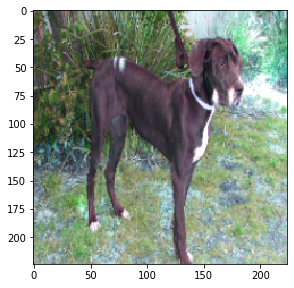

In [0]:
batch = train_data.__getitem__(10)

print(type(batch), type(batch[0]), type(batch[1]))
print(len(batch[0]), batch[1])
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(batch[0])

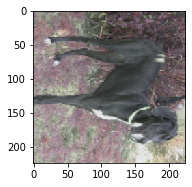

In [0]:
plt.subplot(1, 2, 2)
plt.imshow(batch[0])

In [0]:
train_dataset = Dataloader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_dataset = Dataloader(dataset=val_data, batch_size=batch_size)

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [0]:
print('훈련 데이터, 훈련(훈련/배치), 검증(검증/배치) :', len(train_data), len(train_dataset), len(val_dataset))

훈련 데이터, 훈련(훈련/배치), 검증(검증/배치) : 17000 850 200


## vgg16(conv, dense, model)

In [0]:
class vgg16_conv(tf.keras.layers.Layer):
  def __init__(self, filter_num=None, name=None, kernel_size = (3, 3), pool_size=(2, 2), strides=(2, 2), \
               activation='relu', padding='same', kernel_initialize='he_normal', \
               pooling='max'):
    super(vgg16_conv, self).__init__()
    self.pooling = pooling
    self.filter_num = filter_num

    self.conv1 = Conv2D(self.filter_num, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initialize, name=name + '_conv1')
    self.conv2 = Conv2D(self.filter_num, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initialize, name=name + '_conv2')
    if filter_num > 255:
      self.conv3 = Conv2D(self.filter_num, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initialize, name=name + '_conv3')
    self.bn = BatchNormalization(name=name + '_BN')
    if pooling == 'max':
      self.max_p = MaxPooling2D(pool_size, name=name + '_max_pooling')
    elif pooling == 'avg':
      self.avg_p = AvgPooling2D(pool_size, name=name + '_avg_pooling')

  def call(self, input_image):
    x = self.conv1(input_image)
    x = self.conv2(x)
    if self.filter_num>=256:
      x = self.conv3(x)
    x = self.bn(x)
    if self.pooling == 'max':
      x = self.max_p(x)
    elif self.pooling == 'avg':
      x = self.avg_p(x)
    return x


In [0]:
class vgg16_dense(tf.keras.layers.Layer):
  def __init__(self, dense_unit, classes_num=1, activation='relu'):
    super(vgg16_dense, self).__init__()
    self.flatten = Flatten()
    self.classes_num = classes_num

    self.dense1 = Dense(dense_unit, activation=activation)
    if self.classes_num == 1:
      self.dense_output1 = Dense(classes_num, activation='sigmoid')
    else :
      self.dense_output2 = Dense(classes_num, activation='softmax')

  def call(self, input_conv):
    x = self.flatten(input_conv)
    x = self.dense1(x)
    if self.classes_num == 1:
      x = self.dense_output1(x)
    else:
      self.dense_output2(x)
    return x

In [0]:
def conv_layer(filter_num, name):
  block = vgg16_conv(filter_num, name)
  return block

In [0]:
def dense_layer(dense_unit, classes_num):
  block = vgg16_dense(dense_unit, classes_num)
  return block

In [0]:
class vgg16_model(tf.keras.Model):
  def __init__(self, include_top=True):
    super(vgg16_model, self).__init__()
    self.include_top = include_top

    self.conv_block1 = conv_layer(64, 'block1')
    self.conv_block2 = conv_layer(128, 'block2')
    self.conv_block3 = conv_layer(256, 'block3')
    self.conv_block4 = conv_layer(512, 'block4')
    self.conv_block5 = conv_layer(512, 'block5')
    if self.include_top :
      self.dense_block = dense_layer(256, classes_num=1)

  def call(self, input_image):
    x = self.conv_block1(input_image)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    output = self.conv_block5(x)
    if self.include_top:
      output = self.dense_block(output)
    return output
    

In [0]:
vgg16 = vgg16_model()

## model compile and fit_generator

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [0]:
vgg16.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = vgg16.fit_generator(
    train_dataset,
    steps_per_epoch = 80,
    epochs=epochs,
    validation_data = val_dataset,
    validation_steps = 20)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 80 steps, validate for 20 steps
Epoch 1/5
80/80 [==============================] - 686s 9s/step - loss: 1.2088 - accuracy: 0.4988 - val_loss: 0.5450 - val_accuracy: 0.9850
Epoch 2/5
80/80 [==============================] - 510s 6s/step - loss: 0.6953 - accuracy: 0.4712 - val_loss: 0.6049 - val_accuracy: 0.5125
Epoch 3/5
80/80 [==============================] - 463s 6s/step - loss: 0.6941 - accuracy: 0.4856 - val_loss: 0.5548 - val_accuracy: 0.6700
Epoch 4/5
80/80 [==============================] - 442s 6s/step - loss: 0.6966 - accuracy: 0.4387 - val_loss: 0.6191 - val_accuracy: 0.5775
Epoch 5/5
80/80 [==============================] - 420s 5s/step - loss: 0.6941 - accuracy: 0.5337 - val_loss: 0.6801 - val_accuracy: 0.3825


In [0]:
vgg16.summary()

Model: "vgg16_model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_conv_117 (vgg16_conv)  multiple                  38976     
_________________________________________________________________
vgg16_conv_118 (vgg16_conv)  multiple                  221952    
_________________________________________________________________
vgg16_conv_119 (vgg16_conv)  multiple                  1476352   
_________________________________________________________________
vgg16_conv_120 (vgg16_conv)  multiple                  5901824   
_________________________________________________________________
vgg16_conv_121 (vgg16_conv)  multiple                  7081472   
_________________________________________________________________
vgg16_dense_15 (vgg16_dense) multiple                  6423041   
Total params: 21,143,617
Trainable params: 21,140,673
Non-trainable params: 2,944
____________________________________